## Import Data


In [31]:
# from google.colab import drive
# drive.mount('/content/drive')

In [32]:
# === Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage


In [33]:
# === 1. Load & Cleaning ===
data = pd.read_csv("DukuhKupang.csv")
drop_cols = ['Datetime','Timezone','AQI CN','AQI US','HCHO (ppb)','TVOC (ppb)']
data = data.drop(columns=drop_cols).dropna().drop_duplicates()

In [34]:
print(data.isna().sum())
print(data.isnull().sum())
print(data.duplicated().sum())

PM2.5 (ug/m3)               0
PM10 (ug/m3)                0
CO2 (ppm)                   0
Temperature (Celsius)       0
Temperature (Fahrenheit)    0
Humidity (%)                0
dtype: int64
PM2.5 (ug/m3)               0
PM10 (ug/m3)                0
CO2 (ppm)                   0
Temperature (Celsius)       0
Temperature (Fahrenheit)    0
Humidity (%)                0
dtype: int64
0


In [35]:
data = data.dropna()
data = data.drop_duplicates()
data.duplicated().sum()

0

In [36]:
# --- 3. Deteksi & Hapus Outlier (IQR loop) ---
data_cleaned = data.copy()

while True:
    Q1 = data_cleaned.quantile(0.25)
    Q3 = data_cleaned.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_idx = data_cleaned[
        (data_cleaned < lower_bound) | (data_cleaned > upper_bound)
    ].dropna(how='all').index

    if len(outlier_idx) == 0:
        print("✅ No more outliers detected.")
        break
    else:
        print(f"⚠️ Removing {len(outlier_idx)} outliers...")
        data_cleaned = data_cleaned.drop(outlier_idx)

print(f"Jumlah data akhir: {len(data_cleaned)}")
display(data_cleaned.head())


⚠️ Removing 5026 outliers...
⚠️ Removing 2066 outliers...
⚠️ Removing 987 outliers...
⚠️ Removing 431 outliers...
⚠️ Removing 229 outliers...
⚠️ Removing 135 outliers...
⚠️ Removing 170 outliers...
⚠️ Removing 355 outliers...
✅ No more outliers detected.
Jumlah data akhir: 29565


,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Temperature (Celsius),Temperature (Fahrenheit),Humidity (%)
25,16.0,35,427,37.6,99.6,49
26,12.0,30,426,37.6,99.6,48
27,16.0,35,422,37.5,99.4,50
28,12.0,18,421,37.3,99.1,49
29,11.0,13,424,37.1,98.8,50


In [37]:
print("Final shape setelah cleaning:", data_cleaned.shape)

Final shape setelah cleaning: (29565, 6)


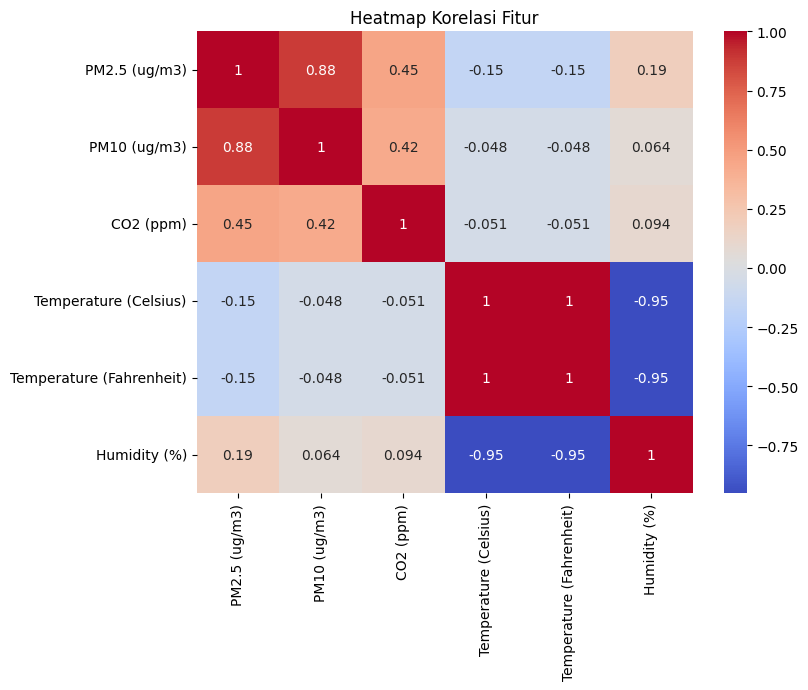

In [38]:
# --- 4. Visualisasi Korelasi ---
plt.figure(figsize=(8,6))
sns.heatmap(data_cleaned.corr(), annot=True, cmap='coolwarm')
plt.title("Heatmap Korelasi Fitur")
plt.show()

# Prepocessing 

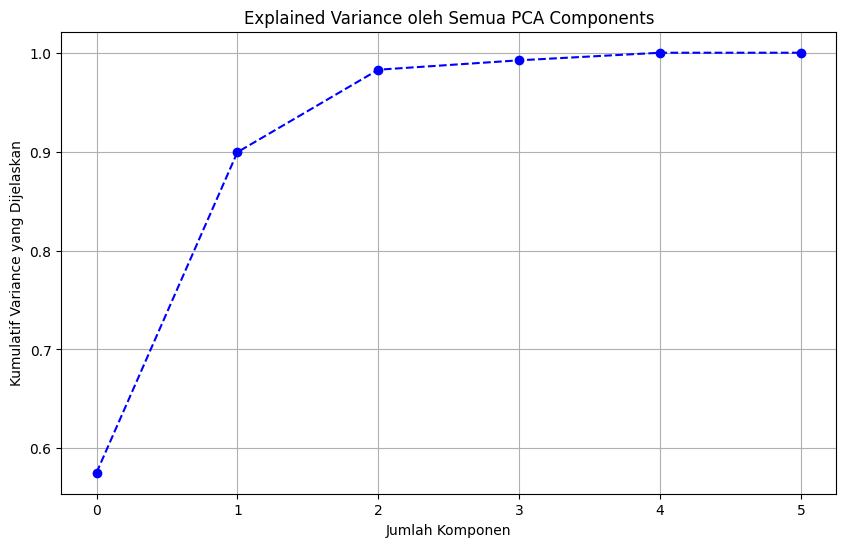

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# === 2. Split & Scaling ===
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === PCA untuk semua komponen ===
pca_full = PCA()  # tanpa n_components, supaya semua komponen dihitung
X_train_pca_full = pca_full.fit_transform(X_train_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Jumlah Komponen')
plt.ylabel('Kumulatif Variance yang Dijelaskan')
plt.title('Explained Variance oleh Semua PCA Components')
plt.grid(True)
plt.show()


In [40]:
# === 2. Split & Scaling ===
X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# === 3. PCA ===
pca = PCA(n_components=2)   # 3 biar bisa 2D/3D plot
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)


In [41]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

print("Explained variance ratio (2 components):", pca.explained_variance_ratio_)
print("Total explained variance:", pca.explained_variance_ratio_.sum())

Explained variance ratio (2 components): [0.57529647 0.32412689]
Total explained variance: 0.8994233645649559


# Clustering

In [42]:
# ==============================
# 3️⃣ AGGLOMERATIVE HIERARCHICAL CLUSTERING
# ==============================
cluster_range = range(2, 11)
silhouette_scores = {}

print("===== AGGLOMERATIVE HIERARCHICAL CLUSTERING =====")
for n_clusters in cluster_range:
    ahc = AgglomerativeClustering(n_clusters=n_clusters, linkage='complete')
    labels = ahc.fit_predict(X_train_pca)
    score = silhouette_score(X_train_pca, labels)
    silhouette_scores[n_clusters] = score
    print(f"n_clusters={n_clusters}, Silhouette Score={score:.4f}")

# Pilih jumlah cluster optimal berdasarkan Silhouette Score
optimal_clusters = max(silhouette_scores, key=silhouette_scores.get)
print(f"\n✅ Jumlah cluster optimal AHC berdasarkan Silhouette Score: {optimal_clusters}")


===== AGGLOMERATIVE HIERARCHICAL CLUSTERING =====
n_clusters=2, Silhouette Score=0.9461
n_clusters=3, Silhouette Score=0.8255
n_clusters=4, Silhouette Score=0.8026
n_clusters=5, Silhouette Score=0.3825
n_clusters=6, Silhouette Score=0.3810
n_clusters=7, Silhouette Score=0.4278
n_clusters=8, Silhouette Score=0.3925
n_clusters=9, Silhouette Score=0.3574
n_clusters=10, Silhouette Score=0.3574

✅ Jumlah cluster optimal AHC berdasarkan Silhouette Score: 2


Silhouette Score = 0.9461, Davies-Bouldin Index = 0.0383


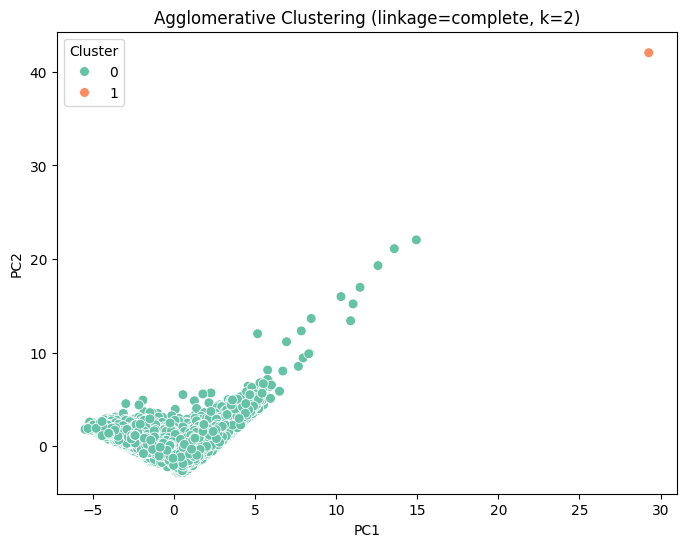

In [ ]:

# === Agglomerative Clustering dengan jumlah cluster optimal ===
ahc_optimal = AgglomerativeClustering(n_clusters=optimal_clusters, linkage='complete')
ahc_labels = ahc_optimal.fit_predict(X_train_pca)

# Evaluasi cluster
sil = silhouette_score(X_train_pca, ahc_labels)
dbi = davies_bouldin_score(X_train_pca, ahc_labels)
print(f"Silhouette Score = {sil:.4f}, Davies-Bouldin Index = {dbi:.4f}")


# %%
# === Visualisasi cluster menggunakan PCA 2D ===
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=ahc_labels, palette="Set2", s=50)
plt.title(f"Agglomerative Clustering (linkage=complete, k={optimal_clusters})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()


Profil Cluster AHC:


,PM2.5 (ug/m3),PM10 (ug/m3),CO2 (ppm),Temperature (Celsius),Temperature (Fahrenheit),Humidity (%)
Cluster_AHC,,,,,,
0,39.734453,76.762688,430.752615,28.750956,83.752255,79.629965
1,1798.800000,2000.000000,509.000000,29.900000,85.700000,78.000000


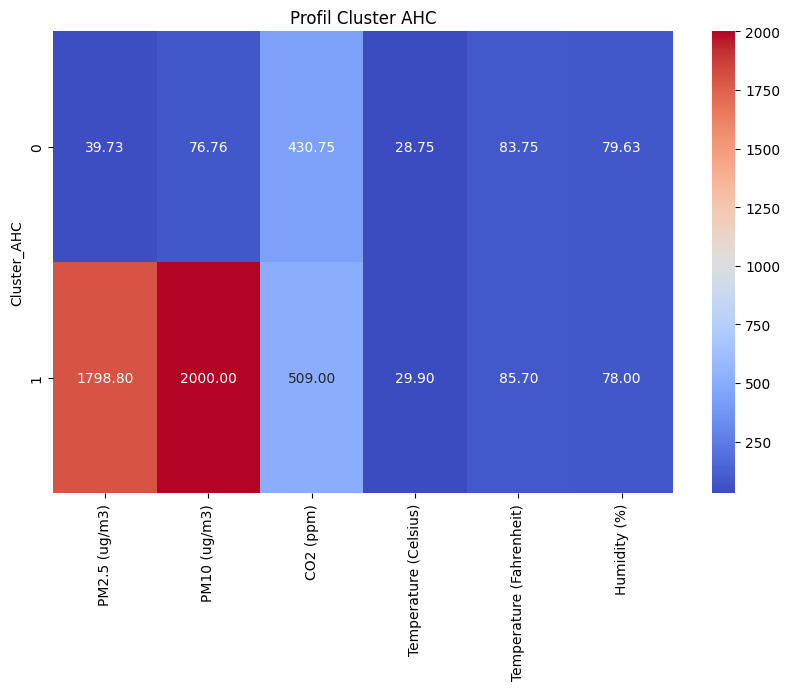

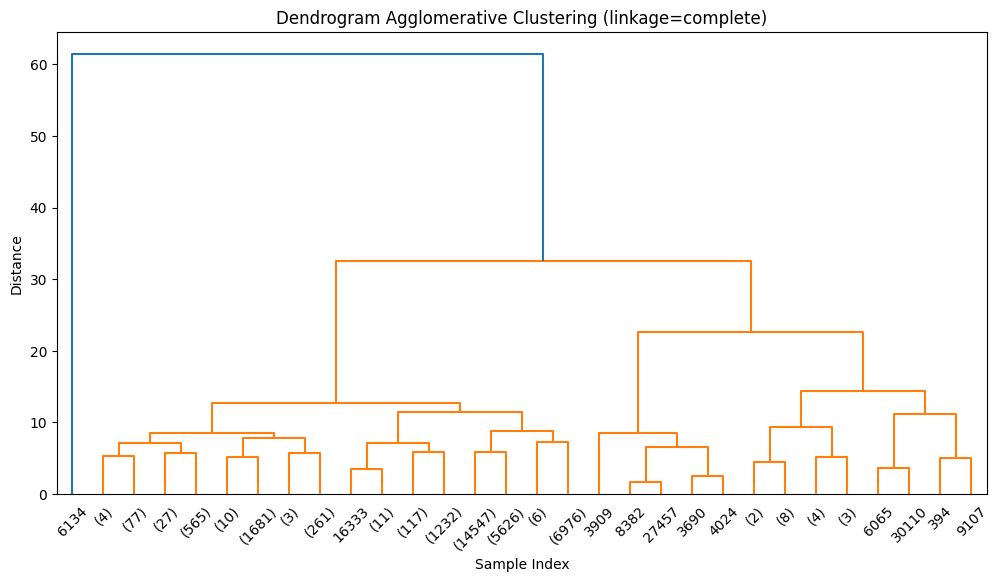

In [44]:
# === Profil Cluster ===
X_train_df = X_train.copy()
X_train_df['Cluster_AHC'] = ahc_labels

cluster_profile = X_train_df.groupby('Cluster_AHC').mean()
print("Profil Cluster AHC:")
display(cluster_profile)

plt.figure(figsize=(10,6))
sns.heatmap(cluster_profile, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Profil Cluster AHC")
plt.show()

# %%
# === Dendrogram untuk melihat struktur hirarkis ===
linked = linkage(X_train_scaled, method='complete')
plt.figure(figsize=(12,6))
dendrogram(linked, truncate_mode='level', p=5, color_threshold=None)
plt.title("Dendrogram Agglomerative Clustering (linkage=complete)")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.show()

In [50]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def compute_metrics(name, labels, X_for_metrics):
    row = {"method": name}
    try:
        row["silhouette"] = silhouette_score(X_for_metrics, labels)
        row["dbi"] = davies_bouldin_score(X_for_metrics, labels)
        row["calinski_harabasz"] = calinski_harabasz_score(X_for_metrics, labels)
    except:
        row["silhouette"], row["dbi"], row["calinski_harabasz"] = np.nan, np.nan, np.nan
    return row

results = []
results.append(compute_metrics("Agglomerative", ahc_labels, X_train_pca))


df_metrics = pd.DataFrame(results).set_index("method")
print("\n=== Metrics table ===")
print(df_metrics)


=== Metrics table ===
               silhouette       dbi  calinski_harabasz
method                                                
Agglomerative      0.9461  0.038337         493.885817


AQI_Category   Good  Moderate  Poor  Satisfactory  Severe  Very Poor
Cluster_AHC                                                         
0             12661      4668  1258         11424     275        884
1                 0         0     0             0       1          0


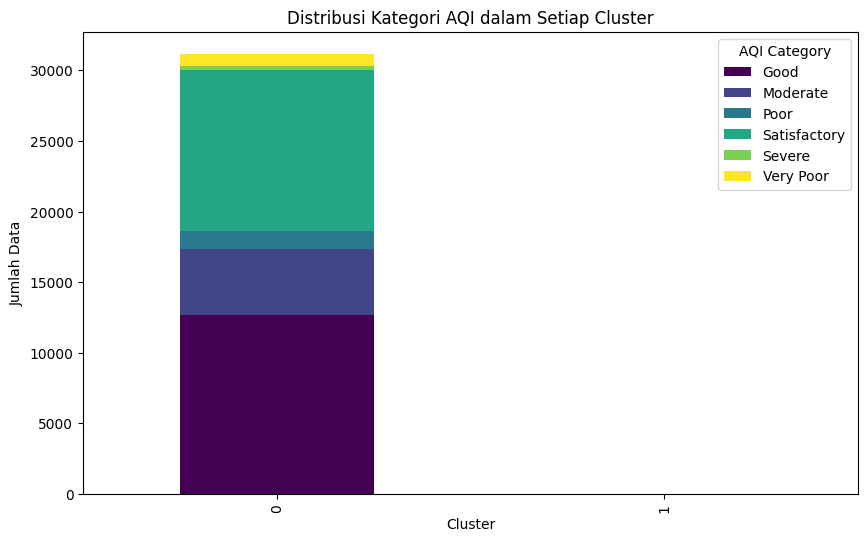

In [48]:
# === 10. Fungsi AQI ===
breakpoints = {
    "PM2.5": [(0, 30, 0, 50),
              (31, 60, 51, 100),
              (61, 90, 101, 200),
              (91, 120, 201, 300),
              (121, 250, 301, 400)],
    
    "PM10": [(0, 50, 0, 50),
             (51, 100, 51, 100),
             (101, 250, 101, 200),
             (251, 350, 201, 300),
             (351, 430, 301, 400)],
}

def calculate_sub_index(pollutant, concentration):
    for (Bmin, Bmax, Imin, Imax) in breakpoints[pollutant]:
        if Bmin <= concentration <= Bmax:
            return ((Imax - Imin)/(Bmax - Bmin)) * (concentration - Bmin) + Imin
    return np.nan

def calculate_aqi_linear(row):
    sub_pm25 = calculate_sub_index("PM2.5", row["PM2.5 (ug/m3)"])
    sub_pm10 = calculate_sub_index("PM10", row["PM10 (ug/m3)"])
    return max(sub_pm25, sub_pm10)

def categorize_aqi(value):
    if value <= 50: return "Good"
    elif value <= 100: return "Satisfactory"
    elif value <= 200: return "Moderate"
    elif value <= 300: return "Poor"
    elif value <= 400: return "Very Poor"
    else: return "Severe"

# Tambahkan kolom AQI ke DataFrame asli
X_train_df["AQI_Value"] = X_train_df.apply(calculate_aqi_linear, axis=1)
X_train_df["AQI_Category"] = X_train_df["AQI_Value"].apply(categorize_aqi)

# %%
# === 11. Crosstab Cluster vs AQI Category ===
cluster_summary = pd.crosstab(X_train_df["Cluster_AHC"], X_train_df["AQI_Category"])
print(cluster_summary)

# Plot stacked bar
cluster_summary.plot(kind="bar", stacked=True, figsize=(10,6), colormap="viridis")
plt.title("Distribusi Kategori AQI dalam Setiap Cluster")
plt.xlabel("Cluster")
plt.ylabel("Jumlah Data")
plt.legend(title="AQI Category")
plt.show()